Connect securely to the database

In [18]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

load_dotenv("config.env")
MONGO_USER = os.getenv("MONGO_USER")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")
client = MongoClient("mongodb://" + MONGO_USER + ":" + MONGO_PASSWORD + "@localhost:27017/")
database = client.rais

Find all the users

In [19]:
users = database.fitbit.distinct('id')

Create the stress score dataframe

In [20]:
import warnings
import statistics
import pandas as pd
from datetime import timedelta
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

stress_df = pd.DataFrame(columns=["id", "date", "stress_score"])

for user in users:
    # obtain the stress data
    user_data = pd.DataFrame(list(
        database.fitbit.find({"$and": [
            {"type": "Stress Score"},
            {"id": user},
            {"data.STRESS_SCORE": {"$gt": 0}} # this removes the calculation fail data (0s)
        ]},
            {"id": 1, "data.DATE": 1, "data.STRESS_SCORE": 1, "_id": 0}
        )
    ))

    # maintain only the users that have stress data / avoid the others
    if len(user_data.columns)>1:
        user_stress = pd.DataFrame(columns=["date", "stress_score"])
        user_stress["date"] = user_data["data"].apply(lambda d: d["DATE"])
        user_stress["date"] = pd.to_datetime(pd.to_datetime(user_stress["date"]).dt.date)
        user_stress["stress_score"] = user_data["data"].apply(lambda d: d["STRESS_SCORE"])

        # maintain only experiment's dates
        user_stress = user_stress.loc[((user_stress['date'] >'2021-05-23') & (user_stress['date'] <'2021-07-26')) | ((user_stress['date'] >'2021-11-14') & (user_stress['date'] <'2022-01-17'))]
        user_stress.reset_index(inplace=True, drop=True)

        # remove duplicates
        user_stress = user_stress.groupby(["date"]).first()
        user_stress.reset_index(inplace=True)

        # >=7 because we have weekly frequency (threshold)
        if len(user_stress)>=7:
            # end with the last appeared Sunday to shape a whole week
            if user_stress["date"][len(user_stress)-1].dayofweek!=6:
                now = user_stress["date"][len(user_stress)-1]
                sunday = now - timedelta(days=((now.isoweekday()) % 7))
                if sunday not in list(user_stress['date']): # add 0 stress score if Sunday not exists
                    user_stress = user_stress.loc[user_stress['date']<sunday]
                    user_stress.loc[len(user_stress.index)] = [sunday, 0]
                    user_stress.index = user_stress.index + 1
                    user_stress = user_stress.sort_index()
                    user_stress.reset_index(inplace=True, drop=True)
                else: # drop the days after Sunday
                    sunday_index = list(user_stress['date']).index(sunday)
                    user_stress = user_stress.iloc[:sunday_index+1]
                    user_stress.reset_index(inplace=True, drop=True)

            # resampling with weekly frequency that avoids 0s/NaNs
            user_stress = user_stress.set_index('date')
            user_stress = user_stress.resample('W-SUN').median()
            user_stress.reset_index(inplace=True)
            user_stress.insert(0, "id", user)

            # shift the date column one day after for better representation
            user_stress['date'] = user_stress['date'].apply(lambda x:x+timedelta(days=1))

            # maintain only experiment's dates / for the one that has 218 days
            user_stress = user_stress.loc[((user_stress['date'] >'2021-05-23') & (user_stress['date'] <'2021-07-26')) | ((user_stress['date'] >'2021-11-14') & (user_stress['date'] <'2022-01-17'))]
            user_stress.reset_index(inplace=True, drop=True)

            # drop NaNs & 0s
            user_stress.dropna(inplace=True)
            user_stress = user_stress[user_stress.stress_score != 0]
            user_stress.reset_index(inplace=True, drop=True)

            # cut to 2 decimals the stress scores and make them float
            user_stress['stress_score'] = user_stress['stress_score'].apply(lambda x:format(x,".2f"))
            user_stress['stress_score'] = pd.to_numeric(user_stress['stress_score'])

            # user average stress score and mean_variation, median_variation, passive_median_variation
            user_stress['average_stress_score'] = statistics.mean(list(user_stress['stress_score']))
            user_stress['median_stress_score'] = statistics.median(list(user_stress['stress_score']))
            user_stress['mean_variation'] = user_stress['stress_score'] - user_stress['average_stress_score']
            user_stress['median_variation'] = user_stress['stress_score'] - user_stress['median_stress_score']
            values = []
            user_stress['passive_median_stress_score'] = 0
            for it in range(len(user_stress['stress_score'])):
                values.append(user_stress['stress_score'][it])
                user_stress['passive_median_stress_score'][it] = statistics.mean(values)
            user_stress['passive_median_variation'] = user_stress['stress_score'] - user_stress['passive_median_stress_score']

            stress_df = pd.concat([stress_df, user_stress], axis=0)
stress_df["id"] = stress_df["id"].apply(lambda t: str(t))
stress_df

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation
0,621e2e8e67b776a24055b564,2021-05-31,81.0,76.1875,75.5,4.8125,5.5,81.000000,0.000000
1,621e2e8e67b776a24055b564,2021-06-07,83.0,76.1875,75.5,6.8125,7.5,82.000000,1.000000
2,621e2e8e67b776a24055b564,2021-06-14,74.0,76.1875,75.5,-2.1875,-1.5,79.333333,-5.333333
3,621e2e8e67b776a24055b564,2021-06-21,76.0,76.1875,75.5,-0.1875,0.5,78.500000,-2.500000
4,621e2e8e67b776a24055b564,2021-06-28,76.0,76.1875,75.5,-0.1875,0.5,78.000000,-2.000000
...,...,...,...,...,...,...,...,...,...
3,621e375b67b776a240290cdc,2021-06-21,82.0,78.9375,79.0,3.0625,3.0,78.375000,3.625000
4,621e375b67b776a240290cdc,2021-06-28,80.0,78.9375,79.0,1.0625,1.0,78.700000,1.300000
5,621e375b67b776a240290cdc,2021-07-05,78.0,78.9375,79.0,-0.9375,-1.0,78.583333,-0.583333
6,621e375b67b776a240290cdc,2021-07-12,76.0,78.9375,79.0,-2.9375,-3.0,78.214286,-2.214286


Create the stai dataframe

In [21]:
stai_df = pd.read_csv('./data/stai.csv')
stai_df = stai_df.iloc[: , 1:-1]
stai_df.drop(["type"], axis=1, inplace=True)
stai_df.rename(columns={"user_id": "id", "submitdate": "date"}, inplace=True)
stai_df["date"] = pd.to_datetime(pd.to_datetime(stai_df["date"]).dt.date)
stai_df

,id,date,stai_stress
0,621e2e8e67b776a24055b564,2021-05-31,45.0
1,621e2e8e67b776a24055b564,2021-06-07,46.0
2,621e2e8e67b776a24055b564,2021-06-28,54.0
3,621e2e8e67b776a24055b564,2021-07-19,46.0
4,621e2e8e67b776a24055b564,2021-07-26,46.0
...,...,...,...
274,621e375b67b776a240290cdc,2021-06-01,59.0
275,621e375b67b776a240290cdc,2021-06-08,60.0
276,621e375b67b776a240290cdc,2021-06-22,60.0
277,621e375b67b776a240290cdc,2021-07-06,60.0


Create the panas dataframe

In [22]:
panas_df = pd.read_csv('./data/panas.csv')
panas_df = panas_df.iloc[: , 1:]
panas_df.drop(["type"], axis=1, inplace=True)
panas_df.rename(columns={"user_id": "id", "submitdate": "date"}, inplace=True)
panas_df["date"] = pd.to_datetime(pd.to_datetime(panas_df["date"]).dt.date)
panas_df

,id,date,positive_affect_score,negative_affect_score
0,621e2e8e67b776a24055b564,2021-07-26,37,14
1,621e2e8e67b776a24055b564,2021-05-31,38,12
2,621e2e8e67b776a24055b564,2021-06-07,37,12
3,621e2e8e67b776a24055b564,2021-06-28,31,12
4,621e2e8e67b776a24055b564,2021-07-19,37,12
...,...,...,...,...
263,621e375367b776a24021e950,2022-01-02,30,33
264,621e375b67b776a240290cdc,2021-06-01,27,29
265,621e375b67b776a240290cdc,2021-06-08,30,30
266,621e375b67b776a240290cdc,2021-06-22,30,30


Merge stress scores and stai dataframe

In [23]:
df_fitbit_stai = stress_df.merge(stai_df, how='left', on=['id', 'date'])
# remove NaNs (no existence of stress score or surveys' response)
df_fitbit_stai.dropna(inplace=True)
df_fitbit_stai.reset_index(inplace=True, drop=True)
df_fitbit_stai

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation,stai_stress
0,621e2e8e67b776a24055b564,2021-05-31,81.0,76.1875,75.5,4.8125,5.5,81.000000,0.000000,45.0
1,621e2e8e67b776a24055b564,2021-06-07,83.0,76.1875,75.5,6.8125,7.5,82.000000,1.000000,46.0
2,621e2e8e67b776a24055b564,2021-06-28,76.0,76.1875,75.5,-0.1875,0.5,78.000000,-2.000000,54.0
3,621e2e8e67b776a24055b564,2021-07-19,75.0,76.1875,75.5,-1.1875,-0.5,76.187500,-1.187500,46.0
4,621e2eaf67b776a2406b14ac,2021-11-29,82.0,80.3750,82.0,1.6250,0.0,82.000000,0.000000,40.0
...,...,...,...,...,...,...,...,...,...,...
71,621e36f967b776a240e5e7c9,2021-06-21,79.0,80.0000,80.5,-1.0000,-1.5,80.000000,-1.000000,45.0
72,621e36f967b776a240e5e7c9,2021-06-28,76.0,80.0000,80.5,-4.0000,-4.5,79.200000,-3.200000,45.0
73,621e36f967b776a240e5e7c9,2021-07-05,82.0,80.0000,80.5,2.0000,1.5,79.666667,2.333333,49.0
74,621e36f967b776a240e5e7c9,2021-07-12,83.0,80.0000,80.5,3.0000,2.5,80.142857,2.857143,50.0


Merge stress scores and panas dataframe

In [24]:
df_fitbit_panas = stress_df.merge(panas_df, how='left', on=['id', 'date'])
# remove NaNs (no existence of stress score or surveys' response)
df_fitbit_panas.dropna(inplace=True)
df_fitbit_panas.reset_index(inplace=True, drop=True)
df_fitbit_panas

,id,date,stress_score,average_stress_score,median_stress_score,mean_variation,median_variation,passive_median_stress_score,passive_median_variation,positive_affect_score,negative_affect_score
0,621e2e8e67b776a24055b564,2021-05-31,81.0,76.1875,75.5,4.8125,5.5,81.000000,0.000000,38.0,12.0
1,621e2e8e67b776a24055b564,2021-06-07,83.0,76.1875,75.5,6.8125,7.5,82.000000,1.000000,37.0,12.0
2,621e2e8e67b776a24055b564,2021-06-28,76.0,76.1875,75.5,-0.1875,0.5,78.000000,-2.000000,31.0,12.0
3,621e2e8e67b776a24055b564,2021-07-19,75.0,76.1875,75.5,-1.1875,-0.5,76.187500,-1.187500,37.0,12.0
4,621e2eaf67b776a2406b14ac,2021-11-29,82.0,80.3750,82.0,1.6250,0.0,82.000000,0.000000,28.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
68,621e36f967b776a240e5e7c9,2021-06-07,85.0,80.0000,80.5,5.0000,4.5,84.500000,0.500000,27.0,37.0
69,621e36f967b776a240e5e7c9,2021-06-21,79.0,80.0000,80.5,-1.0000,-1.5,80.000000,-1.000000,17.0,27.0
70,621e36f967b776a240e5e7c9,2021-06-28,76.0,80.0000,80.5,-4.0000,-4.5,79.200000,-3.200000,28.0,24.0
71,621e36f967b776a240e5e7c9,2021-07-05,82.0,80.0000,80.5,2.0000,1.5,79.666667,2.333333,36.0,17.0


Scatter plot with stress score and stai score

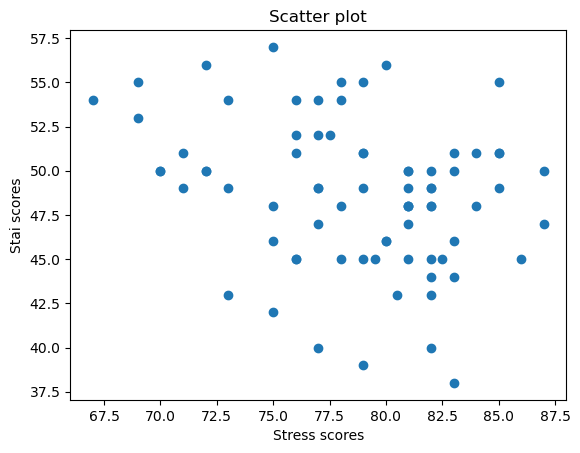

In [25]:
import scipy as scipy
from scipy import stats
import matplotlib.pyplot as plt

stress_scores = list(df_fitbit_stai['stress_score'])
stai_scores = list(df_fitbit_stai['stai_stress'])

plt.scatter(stress_scores, stai_scores)
plt.xlabel("Stress scores")
plt.ylabel("Stai scores")
plt.title("Scatter plot")
plt.show()

Find the correlation between fitbit stress score and stai score

In [26]:
# Pearson correlation
print("Pearson correlation")
corr,p = scipy.stats.pearsonr(stress_scores, stai_scores)
print("Stress scores", corr, "\n")

# Spearman correlation
print("Spearman correlation")
corr = scipy.stats.spearmanr(stress_scores, stai_scores).correlation
print("Stress scores", corr, "\n")

# Kendall correlation
print("Kendall correlation")
corr = scipy.stats.kendalltau(stress_scores, stai_scores).correlation
print("Stress scores", corr, "\n")

Pearson correlation
Stress scores -0.28211735908972646 

Spearman correlation
Stress scores -0.2687749082601475 

Kendall correlation
Stress scores -0.18260756090342398 



Find the correlation between median variation from user baseline and stai score

In [27]:
median_variations = list(df_fitbit_stai['median_variation'])
# Pearson correlation
print("Pearson correlation")
corr_median, p_median = scipy.stats.pearsonr(median_variations, stai_scores)
print("Median variation", corr_median, "\n")
# Spearman correlation
print("Spearman correlation")
corr_median = scipy.stats.spearmanr(median_variations, stai_scores).correlation
print("Median variation", corr_median, "\n")
# Kendall correlation
print("Kendall correlation")
corr_median = scipy.stats.kendalltau(median_variations, stai_scores).correlation
print("Median variation", corr_median, "\n")

Pearson correlation
Median variation -0.060355937516732634 

Spearman correlation
Median variation -0.09744035851930366 

Kendall correlation
Median variation -0.06851688315563866 



Find the correlation between mean variation from user baseline and stai score

In [28]:
mean_variations = list(df_fitbit_stai['mean_variation'])
# Pearson correlation
print("Pearson correlation")
corr_mean, p_mean = scipy.stats.pearsonr(mean_variations, stai_scores)
print("Mean variation", corr_mean, "\n")
# Spearman correlation
print("Spearman correlation")
corr_mean = scipy.stats.spearmanr(mean_variations, stai_scores).correlation
print("Mean variation", corr_mean, "\n")
# Kendall correlation
print("Kendall correlation")
corr_mean = scipy.stats.kendalltau(mean_variations, stai_scores).correlation
print("Mean variation", corr_mean, "\n")

Pearson correlation
Mean variation -0.11776208189892352 

Spearman correlation
Mean variation -0.14780663239095526 

Kendall correlation
Mean variation -0.10969757813161755 



Find the correlation between passive median variation from user baseline and stai score

In [29]:
passive_variations = list(df_fitbit_stai['passive_median_variation'])
# Pearson correlation
print("Pearson correlation")
corr_passive, p_passive = scipy.stats.pearsonr(passive_variations, stai_scores)
print("Passive median variation", corr_passive, "\n")
# Spearman correlation
print("Spearman correlation")
corr_passive = scipy.stats.spearmanr(passive_variations, stai_scores).correlation
print("Passive median variation", corr_passive, "\n")
# Kendall correlation
print("Kendall correlation")
corr_passive = scipy.stats.kendalltau(passive_variations, stai_scores).correlation
print("Passive median variation", corr_passive, "\n")

Pearson correlation
Passive median variation -0.10819303170851029 

Spearman correlation
Passive median variation -0.13639777129513275 

Kendall correlation
Passive median variation -0.09574502661237914 



Scatter plot with stress score and panas positive score

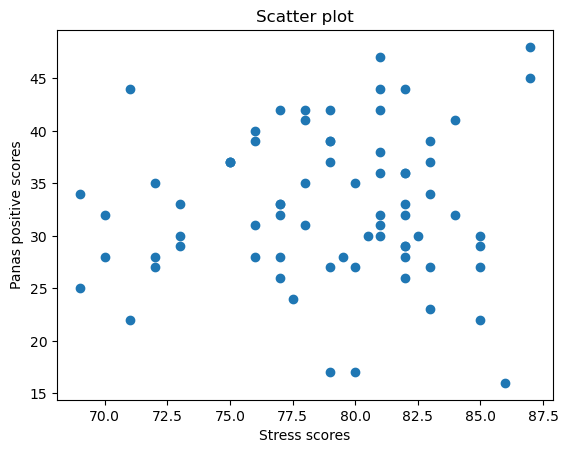

In [30]:
panas_positive_scores = list(df_fitbit_panas['positive_affect_score'])
stress_scores = list(df_fitbit_panas['stress_score'])

plt.scatter(stress_scores, panas_positive_scores)
plt.xlabel("Stress scores")
plt.ylabel("Panas positive scores")
plt.title("Scatter plot")
plt.show()

Find the correlation between stress score and panas positive score

In [31]:
# Pearson correlation
print("Pearson correlation")
corr,p = scipy.stats.pearsonr(stress_scores, panas_positive_scores)
print("Stress scores", corr, "\n")

# Spearman correlation
print("Spearman correlation")
corr = scipy.stats.spearmanr(stress_scores, panas_positive_scores).correlation
print("Stress scores", corr, "\n")

# Kendall correlation
print("Kendall correlation")
corr = scipy.stats.kendalltau(stress_scores, panas_positive_scores).correlation
print("Stress scores", corr, "\n")

Pearson correlation
Stress scores 0.06924674591990454 

Spearman correlation
Stress scores 0.026841814403720805 

Kendall correlation
Stress scores 0.022307131530196107 



Scatter plot with stress score and panas negative score

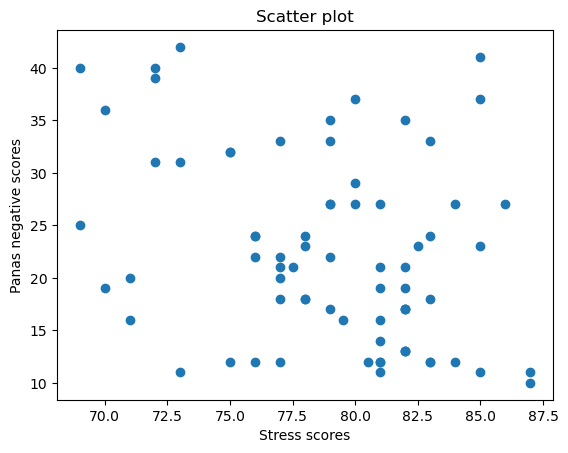

In [32]:
panas_negative_scores = list(df_fitbit_panas['negative_affect_score'])

plt.scatter(stress_scores, panas_negative_scores)
plt.xlabel("Stress scores")
plt.ylabel("Panas negative scores")
plt.title("Scatter plot")
plt.show()

Find the correlation between stress score and panas negative score

In [33]:
# Pearson correlation
print("Pearson correlation")
corr,p = scipy.stats.pearsonr(stress_scores, panas_negative_scores)
print("Stress scores", corr, "\n")

# Spearman correlation
print("Spearman correlation")
corr = scipy.stats.spearmanr(stress_scores, panas_negative_scores).correlation
print("Stress scores", corr, "\n")

# Kendall correlation
print("Kendall correlation")
corr = scipy.stats.kendalltau(stress_scores, panas_negative_scores).correlation
print("Stress scores", corr, "\n")

Pearson correlation
Stress scores -0.31588130337439063 

Spearman correlation
Stress scores -0.2852838300163001 

Kendall correlation
Stress scores -0.21229538764370923 



Extra analysis/visualizations

In [34]:
from dataprep.eda import create_report
create_report(df_fitbit_stai).show_browser()

  0%|          | 0/1711 [00:00<?, ?it/s]

C:\Users\evapa\miniconda3\envs\RAIS-miniproject\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\evapa\miniconda3\envs\RAIS-miniproject\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
